In [4]:
import sys
sys.path.append("../") # go to parent dir


In [26]:
# imports
from cluster_simulator.cluster import Cluster, Tier, bandwidth_share_model, compute_share_model, get_tier, convert_size
from cluster_simulator.phase import DelayPhase, ComputePhase, IOPhase
from cluster_simulator.application import Application
import simpy
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from cluster_simulator.analytics import display_cluster, display_apps, display_run
import numpy as np
from itertools import groupby
from operator import itemgetter
from loguru import logger
import itertools
import time

### Introduction 
The simulation environment is based on simpy, a discrete event simulation library in python.
An application is a sequence of:
- Compute phases:
  - duration: in seconds, as it may run with 1 core
  - cores: number of cores dedicated to the phase, at least 1, cores are shared and limited
  - a function to simulate parallelization (sqrt(1+cores)/sqrt(2))
  - if 10s with 1 core, it may take 10s/1.22 with 2 cores (bad //)
 
- IOPhases:
  - operation : 'read' or 'write'
  - volume: in bytes
  - pattern: 1 for pure sequential, 0 for random, 0.2: 20% seq and 80% random
  - (not implemeted yet): the blocksize, so the bandwidth is considered in the asymptotic part
  
- Application:
  - a linear sequence of phases
  - next phase cannot be executed if previous didn't succeed
  - if an app starts by reading from an empty tier, tier level is automatically adjusted
  - can we launch many apps in parallel ?    


**MIMOUNI, SALIM/io-sea-3.4-analyticsio-sea-3.4-analytics**

In [37]:
# preparing execution environment variables
env = simpy.Environment()
data = simpy.Store(env)
app1 = Application(env, name="app1", # name of the app in the display
                   compute=[0, 15],  # two events, first at 0 and second at 15, and compute between them
                   read=[1e9, 0],    # read 1GB at 0, before compute phase, at the end do nothing (0)
                   write=[0, 10e9],  # write 0GB at first event, and 10GB at the second, after compute phase
                   data=data)        # collected data for monitoring

# app1 : read 1GB -> compute 15s if 1 core is used -> write 10GB

A cluster is a set of:
- compute nodes as shared resources:
   - cores: number of units of computing (can be replaced by CPU or cores depending on the app)
- storage tiers:
   - list of storage tiers with their characteristics:
      - name
      - capacity in GB, also a shared resource
      - a bandwidth (described below)
      - bandwidth factor model:
         - when 2+ cores are used instead of 1, bandwidth*factor (ideally 2+)
         - (not implemented yet) upper bound due to storage connexion bandwidth
      - (not implemented yet, but almost) bandwidth share model:
         - maximum available bandwidth is a shared resource between apps and concurrent phases

In [38]:
nvram_bandwidth = {'read':  {'seq': 780, 'rand': 760},   # throughput for read ops in MB/s
                   'write': {'seq': 515, 'rand': 505}}   # throughput for write ops in MB/s
ssd_bandwidth =   {'read':  {'seq': 210, 'rand': 190},
                   'write': {'seq': 100, 'rand': 100}}   # data is taken from IEEE'2013

In [39]:
# we register the tiers
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth, capacity=80e9)

In [43]:
# we attach the tiers to a cluster:
cluster = Cluster(env, compute_nodes=3,   # number of physical nodes
                       cores_per_node=2,  # available cores per node
                       tiers=[ssd_tier, nvram_tier]) # associate storage tiers to the cluster
                    #          ^tier 0,    ^tier 1, tier...
                    

env.process(app1.run(cluster, placement=[1, 1]))
env.run()

print(f"Execution time = {time.time()-start_time} seconds")

fig = display_run(data, cluster, width=800, height=800)
fig.show()

Execution time = 168.50859904289246 seconds


In [46]:
# process app1, which has 2 IOPhase, for each one we must indicate a data placement
# tiers = [0,     -> for the first IOPhase, we choose tier 0,
#             1]  -> for the second IOPhase, we choose tier 1,
logger.remove()

start_time = time.time()
env = simpy.Environment()
data = simpy.Store(env)
cluster = Cluster(env, compute_nodes=3, cores_per_node=2, tiers=[ssd_tier, nvram_tier])
app1 = Application(env, name="app1", compute=[0, 15], read=[1e9, 0], write=[0, 10e9], data=data)
env.process(app1.run(cluster, placement=[1, 1]))
env.run()

print(f"Execution time = {time.time()-start_time} seconds")

fig = display_run(data, cluster, width=800, height=800)
fig.show()

Execution time = 0.0 seconds


IndexError: list index out of range

## Two apps running in parallel

In [22]:
logger.remove()
env = simpy.Environment()
data = simpy.Store(env)

# we register the tiers
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth, capacity=80e9)
cluster = Cluster(env, compute_nodes=3, cores_per_node=2, tiers=[ssd_tier, nvram_tier])
# defining two apps
app1 = Application(env, name="app1", compute=[0, 15], read=[1e9, 0], write=[0, 10e9], data=data)
app2 = Application(env, name="app2", compute=[0, 15], read=[1e9, 0], write=[0, 1e9], data=data)
# executing apps
env.process(app1.run(cluster, placement=[0, 1]))
env.process(app2.run(cluster, placement=[0, 0]))
env.run()
# display
fig = display_run(data, cluster, width=800)
fig.show()



## Waiting cores for concurrent apps

In [24]:
logger.remove()
env = simpy.Environment()
data = simpy.Store(env)
# we register the tiers and the cluster
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth, capacity=80e9)
cluster = Cluster(env, compute_nodes=1, cores_per_node=1, tiers=[ssd_tier, nvram_tier])

# defining two apps
app1 = Application(env, name="app1", compute=[0, 10], read=[1e9, 0], write=[0, 5e9], data=data)
app2 = Application(env, name="app2", compute=[0, 5], read=[1e9, 0], write=[0, 12e9], data=data)

# executing apps
env.process(app1.run(cluster, placement=[0, 0]))
env.process(app2.run(cluster, placement=[0, 1]))
env.run()
# display
fig = display_run(data, cluster, width=800)
fig.show()
# known bug : idle app phase should cut (or dashed lines) in display
# knwon bug : when releasing core resource, priority go to queued req, not to running app

### More Apps with delay

In [25]:
#logger.remove()
env = simpy.Environment()
data = simpy.Store(env)
# tiers and cluster
ssd_tier = Tier(env, 'SSD', bandwidth=ssd_bandwidth, capacity=200e9)
nvram_tier = Tier(env, 'NVRAM', bandwidth=nvram_bandwidth, capacity=80e9)
cluster = Cluster(env, compute_nodes=1, cores_per_node=10, tiers=[ssd_tier, nvram_tier])
# defining two apps
app1 = Application(env, name="app1", compute=[0, 10], read=[1e9, 0], write=[0, 30e9], data=data)
app2 = Application(env, name="app2", delay = 5, compute=[0, 5], read=[2e9, 0], write=[0, 10e9], data=data)

app3 = Application(env, name="app3", delay = 5, compute=[0, 5], read=[2e9, 0], write=[0, 10e9], data=data)
# executing apps
env.process(app1.run(cluster, placement=[1, 1]))
env.process(app2.run(cluster, placement=[1, 1]))
env.process(app3.run(cluster, placement=[1, 1]))
env.run()
# display
fig = display_run(data, cluster, width=800, height=900)
fig.show()
# known bug : idle app phase should cut (or dashed lines) in display
# knwon bug : when releasing core resource, priority go to queued req, not to running app

Questions:
1. What is a datanode? 
   - an ephemeral tier with dedicated cores, 
   - and a self bandwidth_share_model, 
   - two automatic movements : 
      - prefetch if reading in tier where no data
        - inclure le cout du prefetch depuis le persistent (incluse dans le modèle)        
      - sending back data to a persistent tier
        - appli terminée
        - cout en bandwidth, cpu, indisponibilité du datanode selon la flavour
      
      
2. How to wire an optimization process (example with BBO):
   - in fact in `env.process(app1.run(cluster, tiers=[1, 1]))` placement = tiers = [0 or 1 or 2..., 0 or 1 or 2..., ...]
   - for SBB : placement[i]==2:
      - nodes/workers
      - blocksize
      - other params
      - => adjust resultant bandwidth
   - fitness_value = duration(apps) = get_fitness(env, data, cluster, [apps], placement=bbo.get_params())  
      - but it runs in simulation environement
      - duration of a step is 10-20 us
   

2. Concept of workflow:
   - instead of having sequential phases, we could have phases organized as graph in which:
      - each node is an IOPhase
      - each edge is a ComputePhase
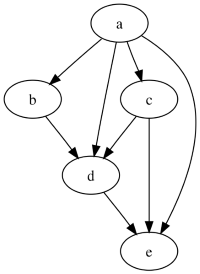